### Install dependencies

In [1]:
# !pip install qiskit

In [2]:
# !pip install qiskit_algorithms

In [3]:
# !pip install qiskit_optimization

In [4]:
# ! pip install qiskit-aer

In [5]:
# !pip install pylatexenc

In [6]:
# !pip install gurobipy

In [7]:
# !pip install deap

In [8]:
# ! python -m pip install --upgrade pip

In [9]:
# !pip install dwave-ocean-sdk

In [10]:
# !pip install dimod

In [11]:
# !pip install qiskit-aqua

In [12]:
# !pip install pennylane

### Import dependencies

In [13]:
# DEPRECATED MODULES

# from qiskit.opflow import PauliSumOp
# from qiskit.opflow import CircuitOp, CircuitStateFn
# from qiskit.opflow.state_fns import StateFn
# from qiskit.opflow.expectations import PauliExpectation
# from qiskit.opflow.converters import CircuitSampler
# from qiskit.opflow.expectations import MatrixExpectation

# from qiskit.algorithms.minimum_eigensolvers import QAOA
# from qiskit.algorithms.optimizers import COBYLA
# from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver

# from qiskit.utils import algorithm_globals


In [14]:
# useful additional packages

# import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import os

from qiskit_optimization.applications import Maxcut


from scipy.optimize import minimize
import time

In [15]:
import gurobipy as gp
from gurobipy import GRB

### Initialize the graph (problem instance)

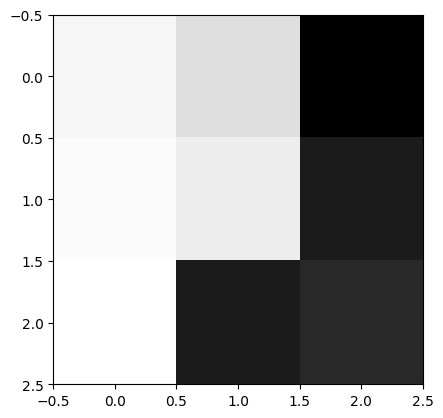

In [16]:
# n = 3

height,width = 3,3

image = np.array([
       [0.92,  0.87, 0.39],
       [0.93,  0.90, 0.45],
       [0.94,  0.45, 0.48]
       ])
plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)

In [17]:
def image_to_grid_graph(gray_img, sigma=0.5):
  # Convert image to grayscale
  # gray_img = np.dot(img, [0.2989, 0.5870, 0.1140])
  h, w = gray_img.shape
  # Initialize graph nodes and edges
  nodes = np.zeros((h*w, 1))
  edges = []
  nx_elist = []
  # Compute node potentials and edge weights
  min_weight = 1
  max_weight = 0
  for i in range(h*w):
    x, y = i//w, i%w
    nodes[i] = gray_img[x,y]
    if x > 0:
      j = (x-1)*w + y
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x-1,y]])**2 / (2*sigma**2))
      weight = np.exp(-((gray_img[x,y] - gray_img[x-1,y])**2) / (2 * sigma**2))
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x-1,y),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
    if y > 0:
      j = x*w + y-1
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x,y-1]])**2 / (2*sigma**2))
      weight = np.exp(-((gray_img[x,y] - gray_img[x,y-1])**2) / (2 * sigma**2))
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x,y-1),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
  a=-1
  b=1
  normalized_edges = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in edges]
  normalized_nx_elist = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in nx_elist]
  return nodes, edges, nx_elist, normalized_edges, normalized_nx_elist



pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist = image_to_grid_graph(image)

pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist

(array([[0.92],
        [0.87],
        [0.39],
        [0.93],
        [0.9 ],
        [0.45],
        [0.94],
        [0.45],
        [0.48]]),
 [(1, 0, 0.9950124791926823),
  (2, 1, 0.6307788205474283),
  (3, 0, 0.9998000199986667),
  (4, 1, 0.9982016190284373),
  (4, 3, 0.9982016190284373),
  (5, 2, 0.9928258579038134),
  (5, 4, 0.6669768108584744),
  (6, 3, 0.9998000199986667),
  (7, 4, 0.6669768108584744),
  (7, 6, 0.6186596475026226),
  (8, 5, 0.9982016190284373),
  (8, 7, 0.9982016190284373)],
 [((0, 1), (0, 0), 1.0),
  ((0, 2), (0, 1), 0.63),
  ((1, 0), (0, 0), 1.0),
  ((1, 1), (0, 1), 1.0),
  ((1, 1), (1, 0), 1.0),
  ((1, 2), (0, 2), 0.99),
  ((1, 2), (1, 1), 0.67),
  ((2, 0), (1, 0), 1.0),
  ((2, 1), (1, 1), 0.67),
  ((2, 1), (2, 0), 0.62),
  ((2, 2), (1, 2), 1.0),
  ((2, 2), (2, 1), 1.0)],
 [(1, 0, -0.97),
  (2, 1, 0.94),
  (3, 0, -1.0),
  (4, 1, -0.99),
  (4, 3, -0.99),
  (5, 2, -0.96),
  (5, 4, 0.75),
  (6, 3, -1.0),
  (7, 4, 0.75),
  (7, 6, 1.0),
  (8, 5, -0.99),
  (8, 7

To normalize values between $a$ and $b$ :
$$x''' = (b-a)\frac{x - \min{x}}{\max{x} - \min{x}} + a$$

Pos: {(0, 0): (0, 0), (0, 1): (1, 0), (0, 2): (2, 0), (1, 0): (0, -1), (1, 1): (1, -1), (1, 2): (2, -1), (2, 0): (0, -2), (2, 1): (1, -2), (2, 2): (2, -2)}
{((0, 0), (1, 0)): -1.0, ((0, 0), (0, 1)): -1.0, ((0, 1), (1, 1)): -1.0, ((0, 1), (0, 2)): 0.94, ((0, 2), (1, 2)): -0.95, ((1, 0), (2, 0)): -1.0, ((1, 0), (1, 1)): -1.0, ((1, 1), (2, 1)): 0.73, ((1, 1), (1, 2)): 0.73, ((1, 2), (2, 2)): -1.0, ((2, 0), (2, 1)): 0.99, ((2, 1), (2, 2)): -1.0}


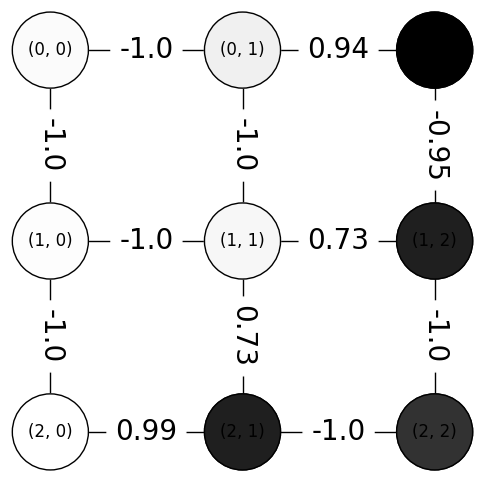

In [18]:
G = nx.grid_2d_graph(image.shape[0], image.shape[1])

# G.add_weighted_edges_from()
G.add_weighted_edges_from(normalized_nx_elist)
# G.add_weighted_edges_from(nx_elist)



def draw(G):
  plt.figure(figsize=(6,6))
  default_axes = plt.axes(frameon=True)
  pos = {(x,y):(y,-x) for x,y in G.nodes()}
  print("Pos:",pos)
  nx.draw_networkx(G,
                  pos=pos,
                  node_color=1-pixel_values,
                  with_labels=True,
                  node_size=3000,
                  cmap=plt.cm.Greys,
                  alpha=1,
                  ax=default_axes)
  nodes = nx.draw_networkx_nodes(G, pos, node_color=1-pixel_values,
                  node_size=3000,
                  cmap=plt.cm.Greys)
  nodes.set_edgecolor('k')
  edge_labels = nx.get_edge_attributes(G, "weight")
  print(edge_labels)
  nx.draw_networkx_edge_labels(G,
                              pos=pos,
                              edge_labels=edge_labels,
                              font_size=20)
  plt.axis('off')
  plt.savefig("2x2_graph.jpg", dpi=600, bbox_inches='tight', pad_inches=0)
draw(G)

Pos: {(0, 0): (0, 0), (0, 1): (1, 0), (0, 2): (2, 0), (1, 0): (0, -1), (1, 1): (1, -1), (1, 2): (2, -1), (2, 0): (0, -2), (2, 1): (1, -2), (2, 2): (2, -2)}
{((0, 0), (0, 1)): 0.0, ((0, 0), (0, 2)): 0.11, ((0, 0), (1, 0)): 0.0, ((0, 0), (1, 1)): 0.0, ((0, 0), (1, 2)): 0.07, ((0, 0), (2, 0)): 0.0, ((0, 0), (2, 1)): 0.07, ((0, 0), (2, 2)): 0.04, ((0, 1), (0, 2)): 0.37, ((0, 1), (1, 0)): 0.0, ((0, 1), (1, 1)): 0.0, ((0, 1), (1, 2)): 0.15, ((0, 1), (2, 0)): 0.0, ((0, 1), (2, 1)): 0.07, ((0, 1), (2, 2)): 0.05, ((0, 2), (1, 0)): 0.09, ((0, 2), (1, 1)): 0.2, ((0, 2), (1, 2)): 0.01, ((0, 2), (2, 0)): 0.06, ((0, 2), (2, 1)): 0.0, ((0, 2), (2, 2)): 0.0, ((1, 0), (1, 1)): 0.0, ((1, 0), (1, 2)): 0.09, ((1, 0), (2, 0)): 0.0, ((1, 0), (2, 1)): 0.18, ((1, 0), (2, 2)): 0.07, ((1, 1), (1, 2)): 0.33, ((1, 1), (2, 0)): 0.0, ((1, 1), (2, 1)): 0.33, ((1, 1), (2, 2)): 0.15, ((1, 2), (2, 0)): 0.08, ((1, 2), (2, 1)): 0.0, ((1, 2), (2, 2)): 0.0, ((2, 0), (2, 1)): 0.38, ((2, 0), (2, 2)): 0.09, ((2, 1), (2, 2)): 

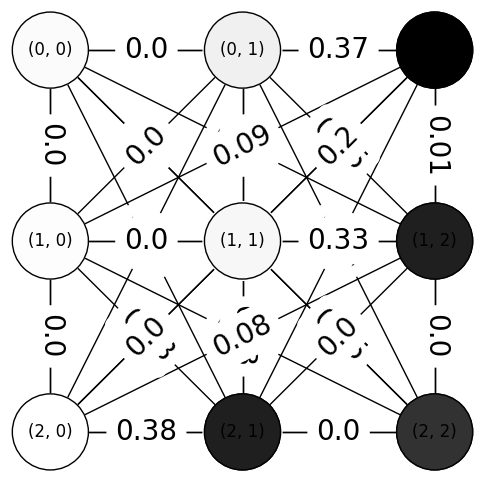

In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

def image_to_grid_graph_full(gray_img, sigma=0.5):
    h, w = gray_img.shape
    nodes = np.zeros((h*w, 1))
    normalized_nx_elist = []

    # Compute node potentials and edge weights
    for i in range(h*w):
        x1, y1 = i // w, i % w
        nodes[i] = gray_img[x1, y1]
        for j in range(i + 1, h * w):
            x2, y2 = j // w, j % w
            pixel_diff = (gray_img[x1, y1] - gray_img[x2, y2]) ** 2
            dist = euclidean((x1, y1), (x2, y2)) ** 2
            weight = (1 - np.exp(-pixel_diff / (2 * sigma**2))) / dist
            normalized_nx_elist.append(((x1, y1), (x2, y2), np.round(weight, 2)))

    return nodes, normalized_nx_elist

# Example usage
height, width = 3, 3
image = np.array([
    [0.92, 0.87, 0.39],
    [0.93, 0.90, 0.45],
    [0.94, 0.45, 0.48]
])
pixel_values, normalized_nx_elist = image_to_grid_graph_full(image)

G = nx.Graph()
G.add_nodes_from([(i // width, i % width) for i in range(height * width)])
G.add_weighted_edges_from(normalized_nx_elist)

# Display the image
# plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
# plt.show()
draw(G)

## Experiments

#### Generate Problem Instance

In [20]:
def image_to_grid_graph(gray_img, sigma=0.5):
  # Convert image to grayscale
  # gray_img = np.dot(img, [0.2989, 0.5870, 0.1140])
  h, w = gray_img.shape
  # Initialize graph nodes and edges
  nodes = np.zeros((h*w, 1))
  edges = []
  nx_elist = []
  # Compute node potentials and edge weights
  min_weight = 1
  max_weight = 0
  for i in range(h*w):
    x, y = i//w, i%w
    nodes[i] = gray_img[x,y]
    if x > 0:
      j = (x-1)*w + y
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x-1,y]])**2 / (2*sigma**2))
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x-1,y])**2) / (2 * sigma**2))
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x-1,y),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
    if y > 0:
      j = x*w + y-1
      # weight = np.exp(-dist.euclidean([gray_img[x,y]], [gray_img[x,y-1]])**2 / (2*sigma**2))
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x,y-1])**2) / (2 * sigma**2))
      # print('weight',weight)
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x,y-1),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
  a=-1
  b=1
  if max_weight-min_weight:
    normalized_edges = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,2)) for node1,node2,edge_weight in nx_elist]
  else:
    normalized_edges = [(node1,node2,-1*np.round(edge_weight,2)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(edge_weight,2)) for node1,node2,edge_weight in nx_elist]
  return nodes, edges, nx_elist, normalized_edges, normalized_nx_elist

In [21]:
def generate_problem_instance(height,width):
  image = np.random.rand(height,width)
  # plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
  pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist = image_to_grid_graph(image)
  G = nx.grid_2d_graph(image.shape[0], image.shape[1])
  G.add_weighted_edges_from(normalized_nx_elist)
  return G, image

In [22]:
def generate_binary_problem_instance(height,width):
  image = np.random.rand(height,width)
  # print(image)
  image[image < 0.5] = 0
  image[image >= 0.5] = 1
  # print(image)
  # plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
  pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist = image_to_grid_graph(image)
  # print('normalized_elist',normalized_elist)
  # print('normalized_nx_elist',normalized_nx_elist)
  G = nx.grid_2d_graph(image.shape[0], image.shape[1])
  G.add_weighted_edges_from(normalized_nx_elist)
  return G, image

G.number_of_nodes(): 4
nx.adjacency_matrix(G).todense() 
 [[ 0.    1.   -0.99  0.  ]
 [ 1.    0.    0.    1.  ]
 [-0.99  0.    0.   -0.99]
 [ 0.    1.   -0.99  0.  ]]


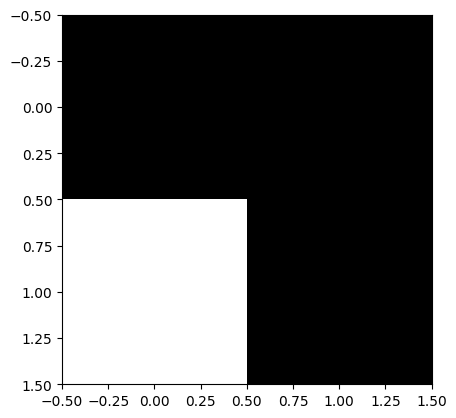

In [23]:
G, image = generate_binary_problem_instance(2,2)
print("G.number_of_nodes():",G.number_of_nodes())
print("nx.adjacency_matrix(G).todense() \n",nx.adjacency_matrix(G).todense())
plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)

In [24]:
nx.adjacency_matrix(G).todense()

array([[ 0.  ,  1.  , -0.99,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  1.  ],
       [-0.99,  0.  ,  0.  , -0.99],
       [ 0.  ,  1.  , -0.99,  0.  ]])

In [25]:
# G, image = generate_binary_problem_instance(2,2)
# print("G.number_of_nodes():",G.number_of_nodes())
# print("nx.adjacency_matrix(G).todense() \n",nx.adjacency_matrix(G).todense())

In [26]:
def draw(G, image):
  pixel_values = image
  plt.figure(figsize=(8,8))
  default_axes = plt.axes(frameon=True)
  pos = {(x,y):(y,-x) for x,y in G.nodes()}
  nx.draw_networkx(G,
                  pos=pos,
                  node_color=1-pixel_values,
                  with_labels=True,
                  node_size=3000,
                  cmap=plt.cm.Greys,
                  alpha=0.8,
                  ax=default_axes)
  nodes = nx.draw_networkx_nodes(G, pos, node_color=1-pixel_values,
                  node_size=3000,
                  cmap=plt.cm.Greys)
  nodes.set_edgecolor('k')
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G,
                              pos=pos,
                             edge_labels=edge_labels)

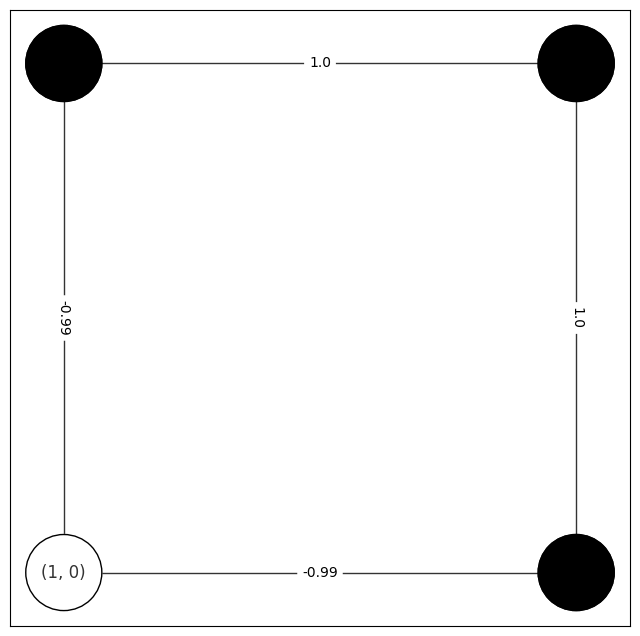

In [27]:
draw(G, image)

#### Minimal Encoding

In [28]:
from qiskit import Aer, execute
# from qiskit.visualization import plot_histogram
# from qiskit.quantum_info import Statevector
import numpy as np

In [29]:
from qiskit.circuit import ParameterVector

In [30]:
from qiskit import QuantumCircuit
from math import log2, ceil

In [31]:
def get_circuit(nq, n_layers):
  theta = ParameterVector('θ', length=nq*n_layers)
  qc = QuantumCircuit(nq)
  qc.h(range(nq))

  for layer_i in range(n_layers):
    # if layer_i%2:
    for qubit_i in range(nq - 1):
      qc.cx(qubit_i, (qubit_i + 1)%nq)
    for qubit_i in range(nq):
      qc.ry(theta[(nq*layer_i)+qubit_i], qubit_i)
  return qc

In [32]:
def get_projectors(probabilities, n_c):
  P = [0] * n_c
  P1 = [0] * n_c
  for k, v in probabilities.items():
    index = int(k[1:], 2)
    P[index] += v
    if k[0] == '1':
      P1[index] += v
  return P, P1

def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    cost = 0
    for i in range(len(x)):
        for j in range(len(x)):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    return cost

def evaluate_cost(params, circuit, qubo_matrix):
  global ultimate_valid_probabilities
  global penultimate_valid_probabilities
  global optimization_iteration_count
  global n_shots
  optimization_iteration_count += 1
  # Create a copy of the circuit to avoid modifying the original
  working_circuit = circuit.copy()

  # Apply measurements
  working_circuit.measure_all()

  # Bind the parameters to the circuit
  bound_circuit = working_circuit.assign_parameters(params)

  # Run the circuit on a simulator

  # n_shots = 8192
  # n_shots = 16384
  # n_shots = 32768
  simulator = Aer.get_backend('qasm_simulator')
  job = execute(bound_circuit, simulator, shots=n_shots)
  result = job.result()
  counts = result.get_counts()

  # Compute the probabilities of the states
  probabilities = {state: counts[state] / n_shots for state in counts}
  # print('probabilities',probabilities)
  # print('ultimate_valid_probabilities',ultimate_valid_probabilities)
  # print('penultimate_valid_probabilities',penultimate_valid_probabilities)
  n_c = 2**(len(list(probabilities.keys())[0])-1)
  # n_c = qubo.shape[0]
  P, P1 = get_projectors(probabilities, n_c)

  if 0 in P:
    return 100000
  else:
    # Update the last valid probabilities
    penultimate_valid_probabilities = ultimate_valid_probabilities.copy()
    ultimate_valid_probabilities = probabilities.copy()

  cost = 0
  for i in range(len(qubo_matrix)):
    for j in range(len(qubo_matrix)):
      if i==j:
        cost += qubo_matrix[i][j] * P1[i]/P[i]
      else:
        cost += (qubo_matrix[i][j]*P1[i]*P1[j])/(P[i]*P[j])
  # binary_string = decode_probabilities(probabilities)
  # print('Binary String :', binary_string)
  # min_cut_cost = 0
  # for i in range(len(binary_string)):
    # for j in range(len(binary_string)):
      # min_cut_cost = min_cut_cost + qubo_matrix[i][j]*binary_string[i]*(1-binary_string[j])
  # print('min_cut_cost :', min_cut_cost)
  print(f'@ Iteration {optimization_iteration_count} Cost :',cost)
  return cost

def get_final_measurement_binary_string(circuit, params):
  # Create a copy of the circuit to avoid modifying the original
  working_circuit = circuit.copy()
  # Apply measurements
  working_circuit.measure_all()
  # Bind the parameters to the circuit
  bound_circuit = working_circuit.assign_parameters(params)
  # Run the circuit on a simulator
  simulator = Aer.get_backend('qasm_simulator')
  job = execute(bound_circuit, simulator, shots=1024)
  result = job.result()
  counts = result.get_counts()
  # Compute the probabilities of the states
  probabilities = {state: counts[state] / 1024 for state in counts}
  return probabilities

def decode_probabilities(probabilities):
  binary_solution = []
  n_r = len(list(probabilities.keys())[0])-1
  n_c = 2**(n_r)
  for i in range(n_c):
    if '0' + format(i, 'b').zfill(n_r) in probabilities and '1' + format(i, 'b').zfill(n_r) in probabilities:
      if probabilities['0' + format(i, 'b').zfill(n_r)] > probabilities['1' + format(i, 'b').zfill(n_r)]:
        binary_solution.append(0)
      else:
        binary_solution.append(1)
    elif '0' + format(i, 'b').zfill(n_r) in probabilities:
      binary_solution.append(0)
    elif '1' + format(i, 'b').zfill(n_r) in probabilities:
      binary_solution.append(1)
  return binary_solution

def decode_binary_string(x, height, width):
  mask = np.zeros([height, width])
  for index,segment in enumerate(x):
    mask[index//width,index%width]=segment
  return mask

In [34]:
# x_1 = 'basis state of the ancilla qubit whose register qubits are in the state (00) with high probability' = 1
# x_2 = 'basis state of the ancilla qubit whose register qubits are in the state (01) with high probability' = 1
# x_3 = 'basis state of the ancilla qubit whose register qubits are in the state (10) with high probability' = 0
# x_4 = 'basis state of the ancilla qubit whose register qubits are in the state (11) with high probability' = 0

In [35]:
def minimal_encoding(G, initial_params, n_layers = 1, max_iter = 2000, optimizer_method = 'COBYLA'):
  w = nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(-w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {int(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {(int(iy),int(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix and abs(quadratic[iy, ix])!=0}
  nc = len(linear)
  nr = ceil(log2(nc))
  nq = nr + 1
  # qubo = np.zeros((nc, nc))
  # np.fill_diagonal(qubo, list(linear.values()))
  # for (i, j), value in quadratic.items():
  #   qubo[i, j] = qubo[j, i] = value
  qc = get_circuit(nq, n_layers)
  # initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq*n_layers)
  global ultimate_valid_probabilities
  global penultimate_valid_probabilities
  global optimization_iteration_count
  ultimate_valid_probabilities = []
  penultimate_valid_probabilities = []
  optimization_iteration_count = 0
  
  # Correct way to call the minimize function
  # options = {'maxiter': max_iter, 'rhoend':1e-8, 'maxfun':max_iter, 'disp':None, 'catol':2e-8}
  options = {}
  optimization_result = minimize(
      fun=evaluate_cost,
      x0=initial_params,  # Initial guess for the parameters
      args=(qc, w),    # Additional arguments passed to evaluate_cost
      method=optimizer_method,
      bounds=tuple([(-np.pi, np.pi) for _ in range(len(initial_params))]),
      options=options)
  if not len(ultimate_valid_probabilities):
    return False, [0]*nc, 0, 0, [0]*initial_params
  binary_string_solution = decode_probabilities(ultimate_valid_probabilities)
  minimization_cost = optimization_result.fun
  optimal_params = optimization_result.x
  cut_cost = 0
  cut_cost = objective_value(np.array(list(map(int,binary_string_solution))), w)
  # print("W.shape :",w.shape)
  # print("len(binary_string_solution) :",len(binary_string_solution))
  # for i in range(len(binary_string_solution)):
    # for j in range(len(binary_string_solution)):
      # cut_cost = cut_cost + w[i,j]*binary_string_solution[i]*(1-binary_string_solution[j])
  return optimization_result.success, binary_string_solution, minimization_cost, cut_cost, optimal_params


In [36]:
from scipy.optimize import differential_evolution

In [37]:
def minimal_encoding_2(G, initial_params, n_layers = 1, max_iter = 200, optimizer_method = 'COBYLA'):
  w = nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(-w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {int(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {(int(iy),int(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix and abs(quadratic[iy, ix])!=0}
  nc = len(linear)
  nr = ceil(log2(nc))
  nq = nr + 1
  # qubo = np.zeros((nc, nc))
  # np.fill_diagonal(qubo, list(linear.values()))
  # for (i, j), value in quadratic.items():
  #   qubo[i, j] = qubo[j, i] = value
  qc = get_circuit(nq, n_layers)
  # initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq*n_layers)
  global ultimate_valid_probabilities
  global penultimate_valid_probabilities
  global optimization_iteration_count
  ultimate_valid_probabilities = []
  penultimate_valid_probabilities = []
  optimization_iteration_count = 0
  
  # Correct way to call the minimize function
  # options = {'maxiter': max_iter, 'rhoend':1e-8, 'maxfun':max_iter, 'disp':None, 'catol':2e-8}
  # minimizer_kwargs = {"method": optimizer_method}
  optimization_result = differential_evolution(
      func=evaluate_cost,
      args = (qc, w),
      # x0=initial_params,  # Initial guess for the parameters
      bounds=tuple([(-np.pi, np.pi) for _ in range(len(initial_params))])
      # minimizer_kwargs=minimizer_kwargs,
      # maxiter=max_iter
      )
  if not len(ultimate_valid_probabilities):
    return False, [0]*nc, 0, 0, [0]*initial_params
  binary_string_solution = decode_probabilities(ultimate_valid_probabilities)
  minimization_cost = optimization_result.fun
  optimal_params = optimization_result.x
  cut_cost = 0
  cut_cost = objective_value(np.array(list(map(int,binary_string_solution))), w)
  # print("W.shape :",w.shape)
  # print("len(binary_string_solution) :",len(binary_string_solution))
  # for i in range(len(binary_string_solution)):
    # for j in range(len(binary_string_solution)):
      # cut_cost = cut_cost + w[i,j]*binary_string_solution[i]*(1-binary_string_solution[j])
  return optimization_result.success, binary_string_solution, minimization_cost, cut_cost, optimal_params


In [39]:
# tuple([(-np.pi, np.pi) for _ in range(len(initial_params))])

#### Experiments for Minimal Encoding

In [40]:
n_shots = 65536

optimization_max_iter = 10000


# heights = np.arange(2, 17).tolist()
heights = [2,4,8,16]
heights = [2,4,8]
# heights = [8]

# scipy_optimizer_methods = ["COBYLA", "Nelder-Mead", "Powell", "CG", "BFGS", "Newton-CG", "L-BFGS-B", "SLSQP", "trust-const", "dogleg", "trust-ncg", "trust-exact", "trust-krylov"]
# scipy_optimizer_methods = ["COBYLA", "Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "SLSQP"]
scipy_optimizer_methods = ["COBYLA", "Powell", "CG", "BFGS", "L-BFGS-B", "SLSQP"]
scipy_optimizer_methods = ["Powell", "CG", "BFGS", "L-BFGS-B", "SLSQP"]
scipy_optimizer_methods = ["COBYLA"]
# scipy_optimizer_methods = ["Genetic"]


seed = 222
initial_params_seed = 123

ultimate_valid_probabilities = []
penultimate_valid_probabilities = []

optimization_iteration_count = 0


In [41]:
base_path = './'

start_layers = 1
max_layers = 5
initial_params_seed = 123
# scipy_optimizer_methods = ["COBYLA", "Powell", "CG", "BFGS", "L-BFGS-B", "SLSQP"]
# scipy_optimizer_methods = ["Powell", "CG", "BFGS", "L-BFGS-B", "SLSQP"]
scipy_optimizer_methods = ["COBYLA"]


heights = [2,4]

seeds = [111,222,333,444,555]
# seeds = [555]
seeds

[111, 222, 333, 444, 555]

In [ ]:
for seed in seeds:
  report_filename = base_path + 'AncillaBasisStateEncoding_' +  str(seed) + '_' + str(n_shots) + '.txt'
  for height in heights:
    width = height
    print(f'height: {height}, width: {width}, n: {height*width}')
    # G, image = generate_binary_problem_instance(height, width)
    np.random.seed(seed=seed)
    G, image = generate_problem_instance(height, width)
    print("Image Generated: ",image)
    # plt.imshow(image, cmap=plt.cm.gray)
    # plt.show()

    for scipy_optimizer_method in scipy_optimizer_methods:
      # if G.number_of_nodes() <= max_layers:
        # max_layers = G.number_of_nodes()
      # else:
        # max_layers = 30
      print("Maximum number of layers :", max_layers)
      for n_layers in range(start_layers, max_layers+1,1):
        nc = len(G.nodes())
        nr = ceil(log2(nc))
        nq = nr + 1
        # np.random.seed(seed=111)
        initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq*n_layers)
        print(f"Executing QC with {n_layers} layers and {scipy_optimizer_method} optimizer for {height}*{height} image.")
        # try:
        start_time = time.time()
        success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params = minimal_encoding_2(G,
                                                                                                                      initial_params,
                                                                                                                      n_layers = n_layers,
                                                                                                                      max_iter = optimization_max_iter,
                                                                                                                      optimizer_method = scipy_optimizer_method)
        minimal_encoding_tte = (time.time() - start_time)
        # except:
          # print(f"Execution Failed for {n_layers} layers and {scipy_optimizer_method} optimizer for {height}*{height} image.")
          # continue
        print("New NISQ done for",scipy_optimizer_method,"optimizer with a success status :", success_flag)
        print(f"Appending the results of {height}*{height} image using QC with {n_layers} layers and {scipy_optimizer_method} optimizer.")
        row = []
        row.append(int(G.number_of_nodes()))
        row.append(int(height))
        row.append(int(width))
        row.append(success_flag)
        row.append(''.join(map(str, map(int, (minimal_encoding_solution)))))
        row.append(np.round(minimal_encoding_tte,6))
        row.append(n_layers)
        row.append(np.round(minimal_encoding_cut_value,4))
        row.append(np.round(minimal_encoding_value,4))
        row.append(optimization_iteration_count)
        row.append(scipy_optimizer_method)
        # row.append(''.join(map(str, map(float, (optimal_params)))))
        report_file_obj = open(os.path.join(report_filename),'a+')
        report_file_obj.write('__'.join(map(str,row))+'\n')
        report_file_obj.close()
    print('\n')

In [ ]:
def truncate_long_string(s, max_length=20):
    return s if len(s) <= max_length else s[:max_length] + "..."

def style_df(df):
    # Styles for hover and headers
    cell_hover = {'selector': 'tr:hover', 'props': [('background-color', '#707070')]}  # Dark pale color for hover
    headers = {'selector': 'th', 'props': 'background-color: #1D1D1D; color: white;'}

    # Column separator style
    column_separator = {'selector': 'td, th', 'props': 'border-right: 1px solid white;'}

    # Apply the styles
    styled_df = df.style.set_table_styles([cell_hover, headers, column_separator])

    # Style to hide the border for the last column to prevent a double line at the end of the table
    hide_last_border = {'selector': 'td:last-child, th:last-child', 'props': 'border-right: none;'}

    # Combine all styles
    styles = [cell_hover, headers, column_separator, hide_last_border]
    styled_df = styled_df.set_table_styles(styles, overwrite=False)

    return styled_df

In [ ]:
seed = 111

In [ ]:
base_path = './'
report_filename = base_path + 'minimalEncoding_' +  str(seed) + '_' + str(65536) + '.txt'
# report_filename = base_path + 'minimalEncoding_' +  str(seed) + '_' + str(32768) + '.txt'
# report_filename = base_path + 'SampleTestMinimalEncoding_' +  str(seed) + '_' + str(8192) + '.txt'
report_file_obj = open(report_filename,'r')
table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]

base_cols = ['No. of Pixels', 'Height', 'Width']
sub_cols = ['','','']

extra_sub_cols = ['Optimization Success','Result', 'TTE', 'Layers', 'Min-Cut Cost', 'Optimization Cost', 'Iterations', 'Optimizer Method']
base_cols = base_cols+['Minimal Encoding Solver']*len(extra_sub_cols)
sub_cols=sub_cols+extra_sub_cols

column_arrays = [base_cols, sub_cols]

#df = pd.DataFrame(table_contents, columns=table_headers)
df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))

for col in df.columns:
  if len(col) == 2 and col[1] == 'Result':
    df[col] = df[col].apply(lambda x: truncate_long_string(x))

styled_df = style_df(df)#.apply(highlight_row, axis=1)




styled_df

MultiIndex([(          'No. of Pixels',                     ''),
            (                 'Height',                     ''),
            (                  'Width',                     ''),
            ('Minimal Encoding Solver', 'Optimization Success'),
            ('Minimal Encoding Solver',               'Result'),
            ('Minimal Encoding Solver',                  'TTE'),
            ('Minimal Encoding Solver',               'Layers'),
            ('Minimal Encoding Solver',         'Min-Cut Cost'),
            ('Minimal Encoding Solver',    'Optimization Cost'),
            ('Minimal Encoding Solver',           'Iterations'),
            ('Minimal Encoding Solver',     'Optimizer Method')],
           )

In [ ]:
# Convert 'Minimal Encoding Solver' and 'Optimization Cost' columns to float
df[['Minimal Encoding Solver', 'Optimization Cost']] = df[['Minimal Encoding Solver', 'Optimization Cost']].astype(float)

In [ ]:
import cv2
from PIL import Image

In [ ]:
def forest_segmentation(image_path, downsampling_factor = 64, edge_weight_metric = image_to_grid_graph, solver = minimal_encoding):
  d = downsampling_factor

  img = cv2.imread(image_path)
  img = cv2.medianBlur(img, 31)
  lower_green = np.array([35, 50, 50])
  upper_green = np.array([90, 255, 255])
  darkgreen_mask = cv2.inRange(cv2.cvtColor(img, cv2.COLOR_BGR2HSV), lower_green, upper_green)
  darkgreen_mask = darkgreen_mask/255
  darkgreen_mask[darkgreen_mask == 0] = -1


  img = np.mean(img, axis = 2)/255
  img = (1-img)*darkgreen_mask

  height, width = img.shape
  new_width = width // d
  new_height = height // d
  img = cv2.resize(img, [new_height,new_width])

  pixel_values, elist, nx_elist, normalized_elist, normalized_nx_elist = edge_weight_metric(img)

  G = nx.grid_2d_graph(img.shape[0], img.shape[1])
  G.add_weighted_edges_from(normalized_nx_elist)

  nc = len(G.nodes())
  nr = ceil(log2(nc))
  nq = nr + 1
  np.random.seed(seed=initial_params_seed)
  initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq*n_layers)
  print(f"Executing QC with {n_layers} layers and {scipy_optimizer_method} optimizer for {height}*{height} image.")
  try:
    start_time = time.time()
    success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params = minimal_encoding(G,
                                                                                                                  initial_params,
                                                                                                                  n_layers = 5,
                                                                                                                  max_iter = optimization_max_iter,
                                                                                                                  optimizer_method = 'COBYLA')
    minimal_encoding_tte = (time.time() - start_time)
  except:
    print(f"Execution Failed for {n_layers} layers and {scipy_optimizer_method} optimizer for {height}*{height} image.")

  output_mask = decode_binary_string(minimal_encoding_solution, img.shape[0], img.shape[1])
  # print(output_mask)

  mask = output_mask.repeat(d, axis=0).repeat(d, axis=1)
  return mask, success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params, minimal_encoding_tte

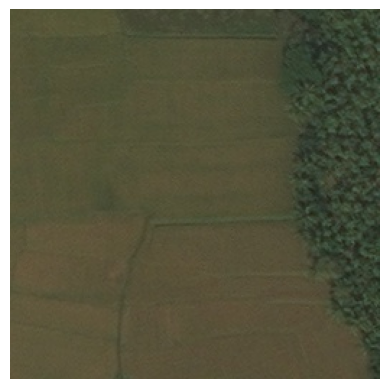

Executing QC with 5 layers and SLSQP optimizer for 256*256 image.
@ Iteration 1 Cost : -0.728912185747345
@ Iteration 2 Cost : 1.7305895767962054
@ Iteration 3 Cost : -0.5390464570521244
@ Iteration 4 Cost : 9.9806723431715
@ Iteration 5 Cost : 4.324486112118636
@ Iteration 6 Cost : -1.266759161053574
@ Iteration 7 Cost : -2.996259483728347
@ Iteration 8 Cost : -0.05176955044783334
@ Iteration 9 Cost : -2.4686747752328713
@ Iteration 10 Cost : -5.072085991258686
@ Iteration 11 Cost : -4.351507384993782
@ Iteration 12 Cost : -4.612336374123284
@ Iteration 13 Cost : -3.617843385229783
@ Iteration 14 Cost : -5.233875722687711
@ Iteration 15 Cost : -3.2233136834884633
@ Iteration 16 Cost : -3.779563505747235
@ Iteration 17 Cost : -6.096848824245156
@ Iteration 18 Cost : -4.923496469840301
@ Iteration 19 Cost : -3.6101569199892634
@ Iteration 20 Cost : -4.13733452825529
@ Iteration 21 Cost : 1.294912188157444
@ Iteration 22 Cost : -4.627567760116434
@ Iteration 23 Cost : -6.012076516469547


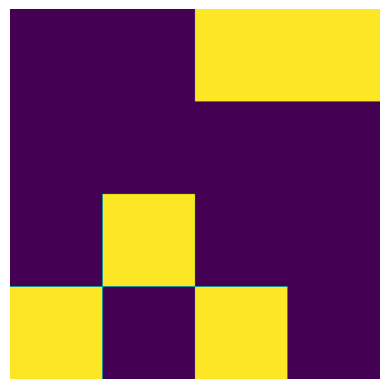

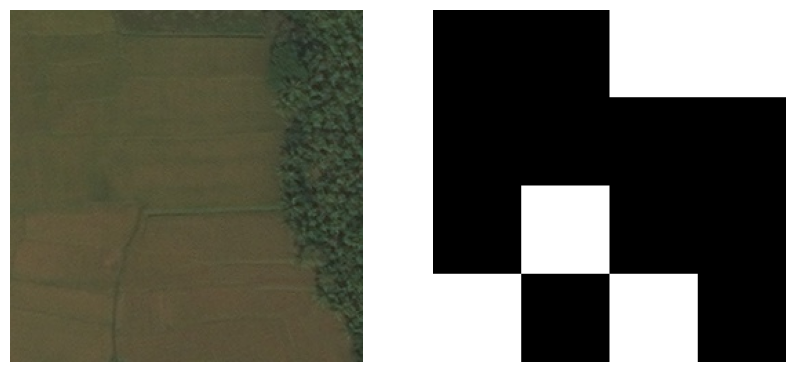

In [ ]:
imgs_paths = ["/content/Forest Segmented/Forest Segmented/images/111335_sat_00.jpg",
            "/content/Forest Segmented/Forest Segmented/images/111335_sat_02.jpg",
            "/content/Forest Segmented/Forest Segmented/images/10452_sat_18.jpg",
            "/content/Forest Segmented/Forest Segmented/images/10452_sat_08.jpg"]


imgs_paths = ["forest/10452_sat_08.jpg"]

for image_path in imgs_paths:
  image = Image.open(image_path)
  plt.imshow(np.asarray(image))
  plt.axis('off')
  plt.show()

  mask, success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params, minimal_encoding_tte = forest_segmentation(image_path)
  plt.imshow(np.asarray(mask))
  plt.axis('off')
  plt.show()

plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# First subplot for the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(np.asarray(image))  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Second subplot for the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(np.asarray(mask), cmap='gray')  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Display the figure with the two images
plt.show()

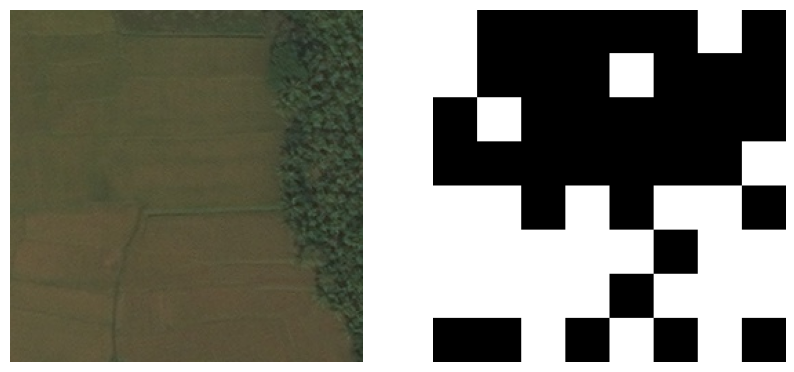

In [ ]:
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# First subplot for the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(np.asarray(image))  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Second subplot for the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(np.asarray(mask), cmap='gray')  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Display the figure with the two images
plt.show()

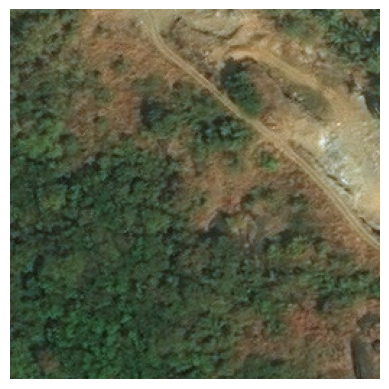

Executing QC with 5 layers and SLSQP optimizer for 256*256 image.
@ Iteration 2 Cost : 17.851737963610756
@ Iteration 4 Cost : 6.367350625027745
@ Iteration 5 Cost : 25.73228004358415
@ Iteration 6 Cost : 17.456673609278063
@ Iteration 7 Cost : 9.483161312491958
@ Iteration 8 Cost : 6.09569841328205
@ Iteration 9 Cost : 6.786947692613628
@ Iteration 10 Cost : 5.01748241977274
@ Iteration 11 Cost : 17.114418813199077
@ Iteration 12 Cost : 13.522210566427036
@ Iteration 13 Cost : 11.276923827238942
@ Iteration 14 Cost : -1.4785940737518537
@ Iteration 15 Cost : 0.6686307198387649
@ Iteration 16 Cost : 4.488637959789864
@ Iteration 17 Cost : 5.229465477601681
@ Iteration 18 Cost : -3.2280965576532696
@ Iteration 19 Cost : 4.8010223474531415
@ Iteration 20 Cost : 6.019865163429833
@ Iteration 21 Cost : 5.5559076017740106
@ Iteration 22 Cost : -0.0802953872287141
@ Iteration 23 Cost : 3.320977132937472
@ Iteration 25 Cost : -6.334777533453622
@ Iteration 26 Cost : 2.13412618075335
@ Iterati

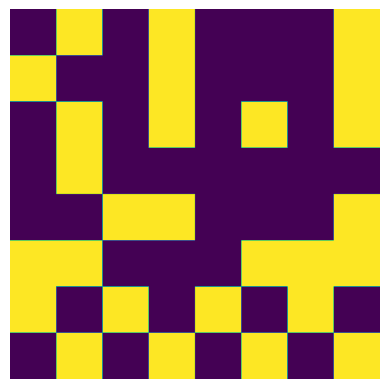

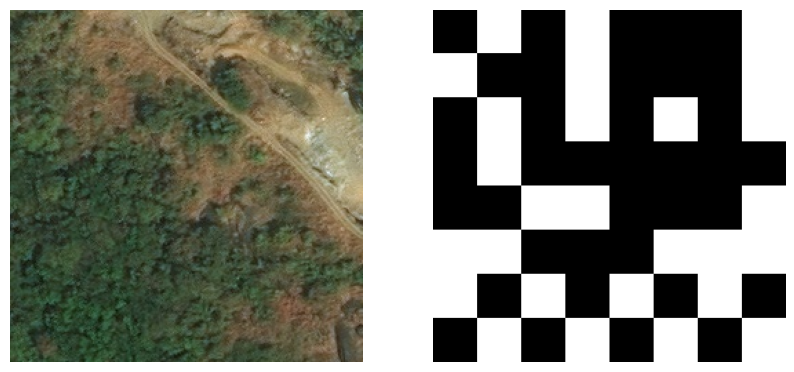

In [ ]:
imgs_paths = ["forest/111335_sat_00.jpg"]

for image_path in imgs_paths:
  image = Image.open(image_path)
  plt.imshow(np.asarray(image))
  plt.axis('off')
  plt.show()

  mask, success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params, minimal_encoding_tte = forest_segmentation(image_path)
  plt.imshow(np.asarray(mask))
  plt.axis('off')
  plt.show()


plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# First subplot for the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(np.asarray(image))  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Second subplot for the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(np.asarray(mask), cmap='gray')  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Display the figure with the two images
plt.show()

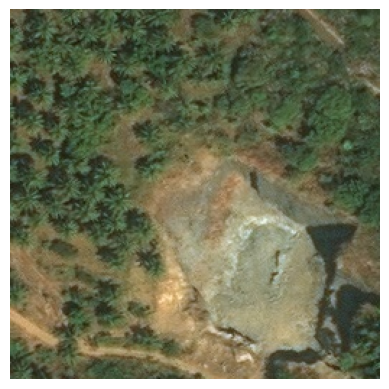

Executing QC with 5 layers and SLSQP optimizer for 256*256 image.
@ Iteration 1 Cost : 21.63528667390829
@ Iteration 2 Cost : 15.455021437135855
@ Iteration 4 Cost : 9.422251308175955
@ Iteration 5 Cost : 20.576467569358645
@ Iteration 6 Cost : 5.390931024223764
@ Iteration 7 Cost : 6.851578515864256
@ Iteration 8 Cost : 8.072374126030592
@ Iteration 9 Cost : -0.6599815593012919
@ Iteration 10 Cost : -0.42867383154419403
@ Iteration 11 Cost : 9.83552390162441
@ Iteration 15 Cost : 3.754091891292214
@ Iteration 18 Cost : 10.665270771375186
@ Iteration 21 Cost : 1.9841867868587695
@ Iteration 22 Cost : 5.33231229103347
@ Iteration 23 Cost : -1.2890748071743452
@ Iteration 26 Cost : 8.42301142137326
@ Iteration 27 Cost : 12.617062433976162
@ Iteration 28 Cost : 5.448934300828726
@ Iteration 29 Cost : 11.362053699549053
@ Iteration 30 Cost : 12.931766338414004
@ Iteration 32 Cost : 15.912092654694305
@ Iteration 34 Cost : -1.7631549527873003
@ Iteration 35 Cost : 28.669999882290455
@ Itera

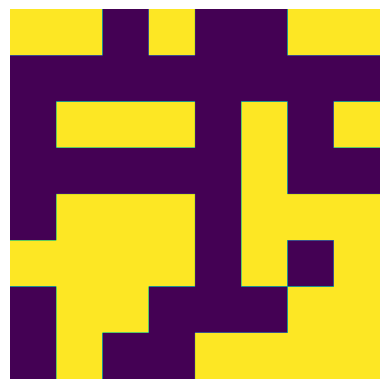

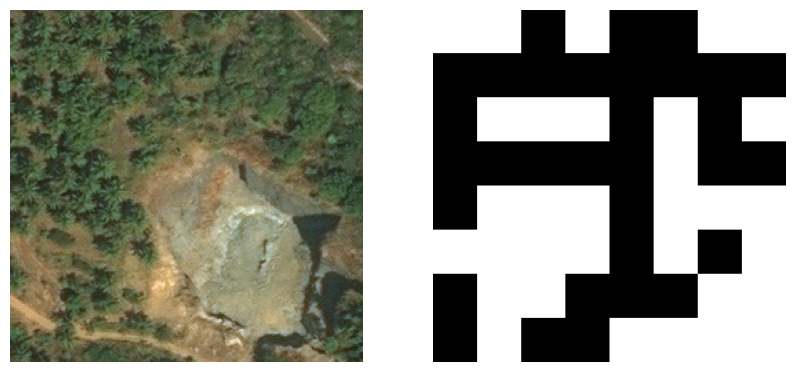

In [ ]:
imgs_paths = ["forest/111335_sat_02.jpg"]

for image_path in imgs_paths:
  image = Image.open(image_path)
  plt.imshow(np.asarray(image))
  plt.axis('off')
  plt.show()

  mask, success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params, minimal_encoding_tte = forest_segmentation(image_path)
  plt.imshow(np.asarray(mask))
  plt.axis('off')
  plt.show()


plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# First subplot for the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(np.asarray(image))  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Second subplot for the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(np.asarray(mask), cmap='gray')  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Display the figure with the two images
plt.show()

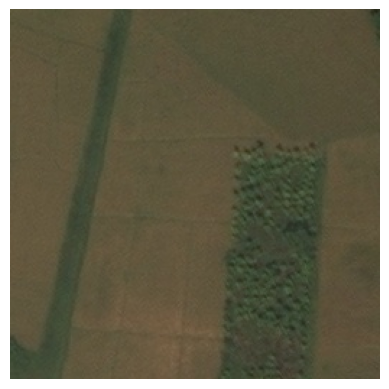

Executing QC with 5 layers and SLSQP optimizer for 256*256 image.
@ Iteration 1 Cost : 19.924895090391075
@ Iteration 2 Cost : 3.3105063414668194
@ Iteration 4 Cost : 1.5059655328936241
@ Iteration 5 Cost : 27.360983000958026
@ Iteration 6 Cost : 14.176539908046061
@ Iteration 7 Cost : -2.111103355095395
@ Iteration 8 Cost : 11.113547760827567
@ Iteration 9 Cost : -11.698034099321639
@ Iteration 10 Cost : -15.301701494849599
@ Iteration 11 Cost : 0.7032236478396368
@ Iteration 12 Cost : -9.390120296336201
@ Iteration 13 Cost : -11.56679721064641
@ Iteration 14 Cost : -6.201629664350283
@ Iteration 15 Cost : -4.420974386422553
@ Iteration 17 Cost : -10.310399512118735
@ Iteration 19 Cost : -8.963787035032105
@ Iteration 20 Cost : -6.612656176890583
@ Iteration 21 Cost : -7.803939017740225
@ Iteration 22 Cost : 9.296881641375348
@ Iteration 23 Cost : -7.787382033174258
@ Iteration 24 Cost : -3.451984877777868
@ Iteration 25 Cost : 3.963590698312405
@ Iteration 26 Cost : -2.84667511499305

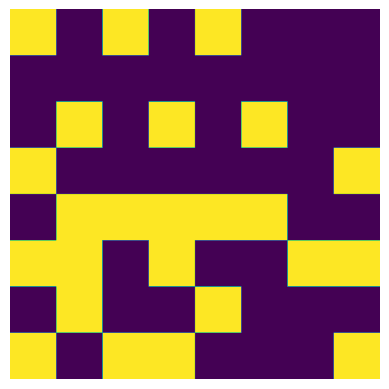

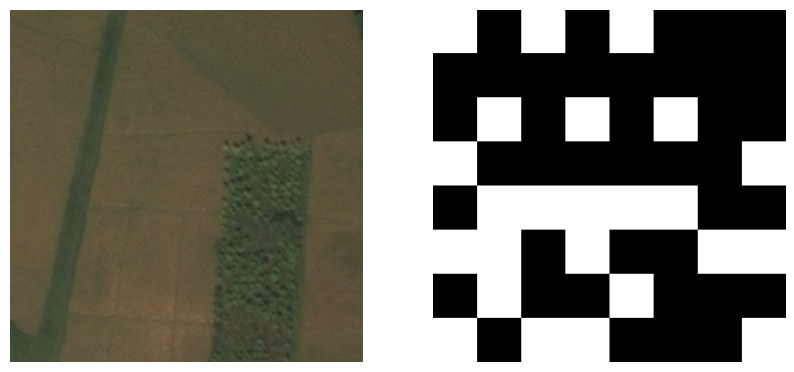

In [ ]:
imgs_paths = ["forest/10452_sat_18.jpg"]

for image_path in imgs_paths:
  image = Image.open(image_path)
  plt.imshow(np.asarray(image))
  plt.axis('off')
  plt.show()

  mask, success_flag, minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params, minimal_encoding_tte = forest_segmentation(image_path)
  plt.imshow(np.asarray(mask))
  plt.axis('off')
  plt.show()


plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# First subplot for the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(np.asarray(image))  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Second subplot for the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(np.asarray(mask), cmap='gray')  # Adjust colormap as needed
plt.axis('off')  # Hide the axis

# Display the figure with the two images
plt.show()

#### Gurobi Solver

In [ ]:
def gurobi_mincut_solver(G):
  w = -1 * nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)

  linear = {int(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {(int(iy),int(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix and abs(quadratic[iy, ix])!=0}

  qubo_matrix = np.zeros([len(linear),len(linear)])
  for key,value in linear.items():
    qubo_matrix[int(key),int(key)] = value
  for key,value in quadratic.items():
    qubo_matrix[int(key[0]),int(key[1])] = value/2
    qubo_matrix[int(key[1]),int(key[0])] = value/2

  #size of the QUBO matrix
  n = qubo_matrix.shape[0]
  model = gp.Model()

  #initialize binary variables
  x = model.addVars(n, vtype=GRB.BINARY)

  #objective function to minimize the QUBO matrix
  obj_expr = gp.quicksum(qubo_matrix[i, j] * x[i] * x[j] for i in range(n) for j in range(n))
  model.setObjective(obj_expr)

  model.setParam('OutputFlag', 0)

  model.optimize()

  if model.status == GRB.OPTIMAL:
    solution = [int(x[i].X) for i in range(n)]
    binary_string = ''.join(str(bit) for bit in solution)
    return binary_string, model.objVal
  else:
    return None, None

#### Choose the solvers for experiments

In [ ]:
#@title Choose the solvers for experiments
brute_force_solver = False#@param {type:"boolean"}
minimum_eigen_solver = False#@param {type:"boolean"}
gurobi_solver = False#@param {type:"boolean"}
qiskit_qaoa_solver = False#@param {type:"boolean"}
new_nisq_solver = False#@param {type:"boolean"}
minimal_encoding_solver = True#@param {type:"boolean"}
dwave_annealer_solver = False#@param {type:"boolean"}


solver_flags = ''.join(map(str,map(int,[brute_force_solver, minimum_eigen_solver, gurobi_solver, qiskit_qaoa_solver, new_nisq_solver, minimal_encoding_solver, dwave_annealer_solver])))
solver_flags

'0000010'

#### Experimental Settings

In [ ]:
table_contents = []

QAOA_reps = 1

max_layers = 1000

# heights = np.arange(2, 17).tolist()
heights = [16,32]

scipy_optimizer_methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr']
scipy_optimizer_methods = ['COBYLA']
other_optimizer_methods = ['Genetic']

seed = 111

# base_path = '/content/drive/MyDrive/Saarland/QAI/newnisq_seg/'
base_path = './'
report_filename = base_path + 'minimalEncoding_seg_report_' + solver_flags + '_' +  str(seed) + '.txt'

problem_instances = {}
ultimate_valid_probabilities = []
penultimate_valid_probabilities = []

# np.random.seed(seed=seed)

#### Executions

In [ ]:
# def get_quality(found_binary_vector, exact_binary_vector):
#   difference = min(sum(abs(found_binary_vector-exact_binary_vector)),sum(abs((1-found_binary_vector)-exact_binary_vector)))
#   quality = 1 - (difference/len(exact_binary_vector))
#   return quality

In [ ]:
# a = np.array([1,0,1,1,1,0])
# b = np.array([0,1,0,0,0,0])

# min(sum(abs(a-b)), sum(abs((1-a)-b)))

In [ ]:
# get_quality(a, b)

In [ ]:
heights

[16, 32]

In [ ]:
for height in heights:
  # for width in widths:
  width = height
  print(f'height: {height}, width: {width}, n: {height*width}')
  # G, image = generate_binary_problem_instance(height, width)
  np.random.seed(seed=seed)
  G, image = generate_problem_instance(height, width)
  # print("Image Generated: ",image)
  start_time = time.time()
  if brute_force_solver:
    brute_force_solution, brute_force_value = bf_solver(G)
    print("BRUTE FORCE DONE!")
  else:
    brute_force_solution, brute_force_value = None, None
  brute_force_tte = (time.time() - start_time)

  start_time = time.time()
  if minimum_eigen_solver:
    minimum_eigen_solution, minimum_eigen_value = me2_solver(G)
    print("Minimum Eigensolver DONE!")
    # minimum_eigen_quality = get_quality(minimum_eigen_solution, brute_force_solution)
  else:
    minimum_eigen_solution, minimum_eigen_value = None, None
    # minimum_eigen_quality = None
  minimum_eigen_tte = (time.time() - start_time)

  start_time = time.time()
  if gurobi_solver:
    gurobi_solution, gurobi_value = gurobi_mincut_solver(G)
    print("Gurobi DONE!")
    # gurobi_quality = get_quality(gurobi_solution, brute_force_solution)
  else:
    gurobi_solution, gurobi_value = None, None
    # gurobi_quality = None
  gurobi_tte = (time.time() - start_time)

  start_time = time.time()
  if qiskit_qaoa_solver:
    qiskit_qaoa_solution, qiskit_qaoa_value = qaoa_solver(G, QAOA_reps)
    print("QAOA DONE!")
    # qiskit_qaoa_quality = get_quality(qiskit_qaoa_solution, brute_force_solution)
  else:
    qiskit_qaoa_solution, qiskit_qaoa_value = None, None
    # qiskit_qaoa_quality = None
  qiskit_qaoa_tte = (time.time() - start_time)
  start_time = time.time()
  if dwave_annealer_solver:
    dwave_annealer_solution, dwave_annealer_value = annealer_solver(G)
    print("ANNEALER DONE!")
    # dwave_annealer_quality = get_quality(dwave_annealer_solution, brute_force_solution)
  else:
    dwave_annealer_solution, dwave_annealer_value = None, None
    # dwave_annealer_quality = None
  dwave_annealer_tte = (time.time() - start_time)

  # start_time = time.time()
  # if new_nisq_genetic_solver:
    # new_nisq_ga_solution, new_nisq_ga_expectation_value, new_nisq_ga_cut_value = new_nisq_ga_solver2(G, population_size = min(10,int(2*G.number_of_nodes())),
                                                                                                      #  crossover_probability = 0.5,
                                                                                                      #  mutation_probability = 0.5,
                                                                                                      #  number_of_generations = min(10,int(2*G.number_of_nodes())))
    # print("NEW NISQ GENETIC ALGORITHM DONE!")
  # else:
    # new_nisq_ga_solution, new_nisq_ga_expectation_value, new_nisq_ga_cut_value = None, None, None
  # new_nisq_ga_tte = (time.time() - start_time)

  # initial_params = np.random.uniform(low=0.5, high=2*np.pi , size=(2**int(np.ceil(np.log2(int(G.number_of_nodes()))))))

  # if G.number_of_nodes() < max_layers:
    # max_layers = G.number_of_nodes()
  # else:
    # max_layers = 1000
  for n_layers in range(400, max_layers+1,100):
    nc = len(G.nodes())
    nr = ceil(log2(nc))
    nq = nr + 1
    np.random.seed(seed=seed)
    initial_params = np.random.uniform(low=-np.pi, high=np.pi, size=nq*n_layers)
    for scipy_optimizer_method in scipy_optimizer_methods:
      start_time = time.time()
      if minimal_encoding_solver:
        print(f"Executing QC with {n_layers} layers and {scipy_optimizer_method} optimizer for {height}*{height} image.")
        minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value, optimal_params = minimal_encoding(G, 
                                                                                                                        initial_params, 
                                                                                                                        n_layers, 
                                                                                                                        optimizer_method = scipy_optimizer_method)
        # minimal_encoding_solution, minimal_encoding_value, minimal_encoding_cut_value = new_nisq_algo_solver(G, scipy_optimizer_method, initial_params)
        print("New NISQ done for",scipy_optimizer_method,"optimizer")
        # new_nisq_quality = get_quality(new_nisq_cut_value, brute_force_value)
      else:
        new_nisq_solution, new_nisq_expectation_value, new_nisq_cut_value = None, None, None
        # new_nisq_quality = None
      minimal_encoding_tte = (time.time() - start_time)
      print(f"Appending the results of {height}*{height} image using QC with {n_layers} layers and {scipy_optimizer_method} optimizer.")
      row = []
      row.append(int(G.number_of_nodes()))
      row.append(int(height))
      row.append(int(width))
      if brute_force_solver:
        row.append(''.join(map(str, map(int, (brute_force_solution)))))
        row.append(brute_force_value)
        row.append(np.round(brute_force_tte,6))
      if minimum_eigen_solver:
        row.append(''.join(map(str, map(int, (minimum_eigen_solution)))))
        row.append(minimum_eigen_value)
        row.append(np.round(minimum_eigen_tte,6))
        # row.append(minimum_eigen_quality)
      if gurobi_solver:
        row.append(''.join(map(str, map(int, (gurobi_solution)))))
        row.append(gurobi_value)
        row.append(np.round(gurobi_tte,6))
        # row.append(minimum_eigen_quality)
      if qiskit_qaoa_solver:
        row.append(''.join(map(str, map(int, (qiskit_qaoa_solution)))))
        row.append(qiskit_qaoa_value)
        row.append(np.round(qiskit_qaoa_tte,6))
        # row.append(qiskit_qaoa_quality)
        row.append(QAOA_reps)
      if dwave_annealer_solver:
        row.append(''.join(map(str, map(int, (dwave_annealer_solution)))))
        row.append(dwave_annealer_value)
        row.append(np.round(dwave_annealer_tte,6))
        # row.append(dwave_annealer_quality)
      # if new_nisq_genetic_solver:
        # row.append(''.join(map(str, map(int, (new_nisq_ga_solution)))))
        # row.append(new_nisq_ga_cut_value)
        # row.append(np.round(new_nisq_ga_tte,6))
        # # row.append(new_nisq_ga_quality)
        # row.append(new_nisq_ga_expectation_value)
      if new_nisq_solver:
        row.append(''.join(map(str, map(int, (new_nisq_solution)))))
        row.append(new_nisq_cut_value)
        row.append(np.round(new_nisq_tte,6))
        # row.append(new_nisq_quality)
        row.append(new_nisq_expectation_value)
        row.append(scipy_optimizer_method)
      if minimal_encoding_solver:
        row.append(''.join(map(str, map(int, (minimal_encoding_solution)))))
        row.append(minimal_encoding_cut_value)
        row.append(np.round(minimal_encoding_tte,6))
        row.append(n_layers)
        row.append(minimal_encoding_value)
        row.append(scipy_optimizer_method)
        # row.append(''.join(map(str, map(float, (optimal_params)))))
      report_file_obj = open(os.path.join(report_filename),'a+')
      report_file_obj.write('__'.join(map(str,row))+'\n')
      report_file_obj.close()
  print('\n')

#### Display report

In [ ]:
def decode_binary_string(x, height, width):
  mask = np.zeros([height, width])
  for index,segment in enumerate(x):
    mask[index//width,index%width]=segment
  return mask

In [ ]:
base_path = '/content/drive/MyDrive/Saarland/QAI/newnisq_seg/'
base_path = './'


report_filename = base_path + 'minimalEncoding_seg_report_' + solver_flags + '_' +  str(seed) + '.txt'
report_filename

'./minimalEncoding_seg_report_0000010_111.txt'

In [ ]:
brute_force_solver = bool(int(report_filename.split('_')[-2][0]))
minimum_eigen_solver = bool(int(report_filename.split('_')[-2][1]))
gurobi_solver = bool(int(report_filename.split('_')[-2][2]))
qiskit_qaoa_solver = bool(int(report_filename.split('_')[-2][3]))
dwave_annealer_solver = bool(int(report_filename.split('_')[-2][4]))
new_nisq_solver = bool(int(report_filename.split('_')[-2][5]))

report_file_obj = open(os.path.join(report_filename),'r')
table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]

In [ ]:
print(brute_force_solver)
print(minimum_eigen_solver)
print(gurobi_solver)
print(qiskit_qaoa_solver)
print(dwave_annealer_solver)
print(new_nisq_solver)

False
False
False
False
False
True


In [ ]:
bf_solver_name = 'Brute Force (Exact)'
me_solver_name = 'Minimum Eigen (Classical)'
gurobi_solver_name = 'Gurobi (Classical SotA)'
qaoa_solver_name = 'Qiskit QAOA'
annealer_solver_name = 'D-Wave 2000Q'
new_nisq_solver_name = 'New NISQ Algorithm'

base_cols = ['No. of Pixels', 'Height', 'Width']
sub_cols = ['','','']

if brute_force_solver:
  base_cols = base_cols+[bf_solver_name]*3
  sub_cols=sub_cols+['Result', 'Value', 'TTE']
if minimum_eigen_solver:
  base_cols = base_cols+[me_solver_name]*3
  sub_cols=sub_cols+['Result', 'Value', 'TTE']
if gurobi_solver:
  base_cols = base_cols+[gurobi_solver_name]*3
  sub_cols=sub_cols+['Result', 'Value', 'TTE']
if qiskit_qaoa_solver:
  base_cols = base_cols+[qaoa_solver_name]*4
  sub_cols=sub_cols+['Result', 'Value', 'TTE', 'QAOA layers (p)']
if dwave_annealer_solver:
  base_cols = base_cols+[annealer_solver_name]*3
  sub_cols=sub_cols+['Result', 'Value', 'TTE']
if new_nisq_solver:
  base_cols = base_cols+[new_nisq_solver_name]*6
  sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Layers', 'Expectation Value', 'Optimizer Method']

column_arrays = [base_cols, sub_cols]


#df = pd.DataFrame(table_contents, columns=table_headers)
df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))

194

In [ ]:
for row in range(len(df)):
    print(df[('New NISQ Algorithm','Result')][row])

1111
0100
1011
0100
0000000000000000
1111111111000000
1111111111111111
1111111111011111
0111110111010111
1111111111011010
1101111111011111
1101111111011001
0101111111011011
1110111111011111
1111011101010111
0111111111011010
1111111111011010
1111111111010111
1111011011011111
1111111111011111
1111111111011111
1110111101110111
1111111111011111
1111111111011110
1111111111011111
0110111111111101
0111111111011101
1111111111011111
1111111111011101
1111111111011111
1111111111011011
1111111111011111
1111111111011111
1111111111011111
0111111011011011
1111111111011111



11111111011000101110...

10011100000111101011...
11111100110111111110...
01111011100110100001...
11000011111111101001...
10111100110001001110...
01010111010001111000...
00101101011111010000...
01101000111011101100...
11110100110111001010...
11111111110110000110...
01010100110000101111...
11101011101111110000...
11000000001111111110...
01101111000111011011...
00110101000101111001...
00111001110011111111...
11000000110001001101...


In [ ]:
def truncate_long_string(s, max_length=20):
    return s if len(s) <= max_length else s[:max_length] + "..."

# Apply this function to the specific column(s)
for col in df.columns:
  if len(col) == 2 and col[1] == 'Result':
    df[col] = df[col].apply(lambda x: truncate_long_string(x))

In [ ]:
# def highlight_row(s):
#     should_highlight = abs(round(float(s[(new_nisq_solver_name, 'Value')]), 3)) == abs(round(float(s[(gurobi_solver_name, 'Value')]), 3))
#     return ['background-color: #606f60' if should_highlight else '' for _ in s]

# df = df.apply(highlight_row, axis=1)
# df

In [ ]:
def style_df(df):
    # Styles for hover and headers
    cell_hover = {'selector': 'tr:hover', 'props': [('background-color', '#707070')]}  # Dark pale color for hover
    headers = {'selector': 'th', 'props': 'background-color: #1D1D1D; color: white;'}

    # Column separator style
    column_separator = {'selector': 'td, th', 'props': 'border-right: 1px solid white;'}

    # Apply the styles
    styled_df = df.style.set_table_styles([cell_hover, headers, column_separator])

    # Style to hide the border for the last column to prevent a double line at the end of the table
    hide_last_border = {'selector': 'td:last-child, th:last-child', 'props': 'border-right: none;'}

    # Combine all styles
    styles = [cell_hover, headers, column_separator, hide_last_border]
    styled_df = styled_df.set_table_styles(styles, overwrite=False)

    return styled_df

styled_df = style_df(df)#.apply(highlight_row, axis=1)

styled_df

In [ ]:
# bf_solver_name = 'Brute Force (Exact)'
# me_solver_name = 'Minimum Eigen (Classical)'
# qaoa_solver_name = 'Qiskit QAOA'
# new_nisq_solver_name = 'New NISQ Algorithm'
# annealer_solver_name = 'D-Wave 2000Q'

# #view output table
# def highlight_error(s, column, benchmark_column):
#   is_false = pd.Series(data=False, index=s.index)
#   # is_false[column] = round(float(s.loc[column]),2)<1.0
#   is_false[column] = s.loc[column]>s.loc[benchmark_column]
#   return ['color: #ff8888' if is_false.any() else '' for v in is_false]

# base_cols = ['No. of Pixels', 'Height', 'Width']
# sub_cols = ['','','']

# if brute_force_solver:
#   base_cols = base_cols+[bf_solver_name]*3
#   sub_cols=sub_cols+['Result', 'Value', 'TTE']
# if minimum_eigen_solver:
#   base_cols = base_cols+[me_solver_name]*3
#   sub_cols=sub_cols+['Result', 'Value', 'TTE']
# if qiskit_qaoa_solver:
#   base_cols = base_cols+[qaoa_solver_name]*4
#   sub_cols=sub_cols+['Result', 'Value', 'TTE', 'QAOA layers (p)']
# if dwave_annealer_solver:
#   base_cols = base_cols+[annealer_solver_name]*3
#   sub_cols=sub_cols+['Result', 'Value', 'TTE']
# if new_nisq_solver:
#   base_cols = base_cols+[new_nisq_solver_name]*5
#   sub_cols=sub_cols+['Result', 'Value', 'Expectation Value', 'TTE', 'Optimizer Method']


# column_arrays = [base_cols, sub_cols]


# #df = pd.DataFrame(table_contents, columns=table_headers)
# df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))

# cols = [col for col in df.columns if col[1]=='Result']

# for col in cols:
#   for row_index, result in enumerate(df[col]):
#     # print(result)
#     result_int_list = list(map(int,result))
#     # print(result_int_list)
#     height = int(df.loc[row_index]['Height'])
#     width = int(df.loc[row_index]['Width'])
#     mask = decode_binary_string(result_int_list, height, width)
#     # print(mask)
#     df[col][row_index] = mask

# s = df.style.apply(highlight_error, column=(new_nisq_solver_name, 'Value'), benchmark_column =(me_solver_name, 'Value'), axis=1)

# cell_hover = {  # for row hover use <tr> instead of <td>
#     'selector': 'td:hover',
#     'props': [('background-color', 'grey')]
# }
# index_names = {
#     'selector': '.index_name',
#     'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
# }
# headers = {
#     'selector': 'th:not(.index_name)',
#     'props': 'background-color: #1D1D1D; color: white;'
# }
# s.set_table_styles([cell_hover, index_names, headers])

# # tab:blue : #1f77b4
# # tab:orange : #ff7f0e
# # tab:green : #2ca02c
# # tab:red : #d62728
# # tab:purple : #9467bd
# # tab:brown : #8c564b
# # tab:pink : #e377c2
# # tab:gray : #7f7f7f
# # tab:olive : #bcbd22
# # tab:cyan : #17becf



# def get_nested_column_style(col_name, nested_col_name, border_color='black', bg_color = 'grey'):
#   return {(col_name, nested_col_name):[{'selector': 'th', 'props': 'border-left: 1px solid '+border_color},
#                                          {'selector': 'td', 'props': 'border-left: 1px solid '+ border_color+'; background-color: #'+bg_color}]}

# def get_column_style(col_name, nested_col_names):
#   result_dict = {}
#   for nested_col_name, bg_color in nested_col_names:
#     border_color = 'black'
#     if nested_col_name == 'Result':
#       border_color = 'white'
#     temp = get_nested_column_style(col_name, nested_col_name, border_color, bg_color)
#     result_dict[list(temp.keys())[0]]=list(temp.values())[0]
#   return result_dict

# d1 = {
#     ('No. of Pixels', ''): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
#                                {'selector': 'td', 'props': 'border-left: 1px solid white'}],
#     ('Height', ''): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
#                                {'selector': 'td', 'props': 'border-left: 1px solid white'}],
#     ('Width', ''): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
#                                {'selector': 'td', 'props': 'border-left: 1px solid white'}]}


# # Add colors to columns
# qaoa_layers_col_bg_color = '17becf'
# result_col_bgcolor = '1f77b4'
# value_col_bgcolor = 'ff7f0e'
# tte_col_bgcolor = '2ca02c'
# quality_col_bgcolor = 'bcbd22'
# scipy_optimizer_col_bgcolor = '8c564b'

# if brute_force_solver: d1.update(get_column_style(bf_solver_name,[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor)]))
# if minimum_eigen_solver: d1.update(get_column_style(me_solver_name,[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor)]))
# if qiskit_qaoa_solver: d1.update(get_column_style(qaoa_solver_name,[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor), ('QAOA layers (p)',qaoa_layers_col_bg_color)]))
# if dwave_annealer_solver: d1.update(get_column_style(annealer_solver_name,[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor)]))
# if new_nisq_solver: d1.update(get_column_style(new_nisq_solver_name,[('Result',result_col_bgcolor), ('Value',value_col_bgcolor), ('TTE',tte_col_bgcolor), ('Optimizer Method',scipy_optimizer_col_bgcolor)]))



# s.set_table_styles(d1, overwrite=False, axis=0)

## Testing

In [ ]:
import re

log = """
Optimizer : COBYLA
Binary String : [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
min_cut_cost : -16.0
Cost : 3.738069320991062
Binary String : [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
min_cut_cost : -6.08
Cost : 5.826377945065506
Binary String : [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
min_cut_cost : -12.04
Cost : 2.211177463949834
Binary String : [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
min_cut_cost : -4.099999999999998
Cost : 1.1341298628448997
Binary String : [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
min_cut_cost : -2.04
Cost : 1.6819029627961617
Binary String : [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1]
min_cut_cost : -8.099999999999998
Cost : 1.418465830503904
Binary String : [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]
min_cut_cost : -6.079999999999998
Cost : 1.1015819773719226
Binary String : [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]
min_cut_cost : -8.08
Cost : 0.5678199758644116
Binary String : [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
min_cut_cost : -12.04
Cost : 3.024790445162655
Binary String : [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
min_cut_cost : -8.1
Cost : 3.088233734405291
Binary String : [1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
min_cut_cost : -10.079999999999998
Cost : 5.416265291778577
Binary String : [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
min_cut_cost : -8.059999999999999
Cost : 1.742868694815287
Binary String : [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]
min_cut_cost : -2.1200000000000006
Cost : -1.1451395338402601
Binary String : [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
min_cut_cost : -16.04
Cost : 3.5065076988118715
Binary String : [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
min_cut_cost : 1.9
Cost : 1.8779925198369112
Binary String : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]
min_cut_cost : 7.860000000000001
Cost : -7.464110693099161
Binary String : [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]
min_cut_cost : -0.14000000000000012
Cost : -5.708272643379922
Binary String : [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]
min_cut_cost : 1.88
Cost : -6.999382949349105
Binary String : [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
min_cut_cost : -0.10000000000000009
Cost : -5.723823147065738
Binary String : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]
min_cut_cost : -0.10000000000000009
Cost : 0.09225481354986884
Binary String : [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
min_cut_cost : -8.059999999999999
Cost : -2.7458363323917023
Binary String : [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]
min_cut_cost : 3.8600000000000003
Cost : -3.9977563995878245
Binary String : [0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]
min_cut_cost : -4.119999999999999
Cost : -0.7919296177348738
Binary String : [1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
min_cut_cost : -4.1
Cost : -2.519105893046167
Binary String : [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1]
min_cut_cost : -10.04
Cost : -0.3128594824064488
Binary String : [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
min_cut_cost : -6.059999999999999
Cost : 0.4164776315167602
Binary String : [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]
min_cut_cost : -4.099999999999998
Cost : -1.3686657722252555
Binary String : [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1]
min_cut_cost : 5.84
Cost : -8.420203504472122
Binary String : [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]
min_cut_cost : -2.08
Cost : 0.825304243790345
Binary String : [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]
min_cut_cost : -6.099999999999998
Cost : -4.046968302441338
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]
min_cut_cost : 3.880000000000001
Cost : -8.722525262226272
Binary String : [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : -2.119999999999998
Cost : -3.705070521794493
Binary String : [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]
min_cut_cost : -10.1
Cost : 1.6067861906789385
Binary String : [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]
min_cut_cost : -4.119999999999999
Cost : 2.108272108278964
Binary String : [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
min_cut_cost : -8.06
Cost : -5.961472983245628
Binary String : [1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
min_cut_cost : -4.120000000000001
Cost : 1.3633249242671628
Binary String : [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]
min_cut_cost : -6.12
Cost : 0.4544884858734725
Binary String : [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]
min_cut_cost : -10.1
Cost : 1.4480500301029746
Binary String : [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
min_cut_cost : -12.059999999999999
Cost : 2.634670286836572
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : 3.9
Cost : -9.831123695195693
Binary String : [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
min_cut_cost : -14.04
Cost : 2.5283158831507175
Binary String : [1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
min_cut_cost : -6.079999999999998
Cost : -1.2114685781273102
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
min_cut_cost : -4.1
Cost : -3.039875672998038
Binary String : [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]
min_cut_cost : -8.1
Cost : 1.9532129222802017
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
min_cut_cost : -4.1000000000000005
Cost : -1.9365118722016776
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]
min_cut_cost : -2.08
Cost : -3.544276592005863
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]
min_cut_cost : -10.08
Cost : -3.1910406476090634
Binary String : [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]
min_cut_cost : -12.079999999999998
Cost : 2.6230088753170824
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
min_cut_cost : -2.0800000000000005
Cost : -5.000269269687593
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
min_cut_cost : -8.08
Cost : -1.7430587094901713
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]
min_cut_cost : -4.08
Cost : -8.001002856552534
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]
min_cut_cost : -2.06
Cost : -4.981943010566862
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
min_cut_cost : -4.1
Cost : -4.346312862275549
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
min_cut_cost : -6.0600000000000005
Cost : -6.827024808711158
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
min_cut_cost : -2.0799999999999996
Cost : -6.416215190327892
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : 1.88
Cost : -6.161128273530037
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
min_cut_cost : -4.08
Cost : -2.5002602853766356
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : 1.88
Cost : -5.5754395699523975
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
min_cut_cost : -6.08
Cost : -1.5064762712959225
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
min_cut_cost : 3.9
Cost : -6.951851216550777
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
min_cut_cost : -6.0600000000000005
Cost : -3.710275288107081
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
min_cut_cost : -0.09999999999999964
Cost : -6.62804445106164
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
min_cut_cost : -4.08
Cost : -3.5392318183844247
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]
min_cut_cost : -2.0799999999999996
Cost : -6.526426377902921
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
min_cut_cost : -4.08
Cost : -4.465809310851273
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : 3.9
Cost : -7.973039148280799
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
min_cut_cost : -4.08
Cost : -3.9869185533747027
Binary String : [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : 3.9
Cost : -10.37456834436577
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
min_cut_cost : -0.10000000000000009
Cost : -6.407842903736178
Binary String : [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : -4.119999999999999
Cost : 0.06387068760620625
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
min_cut_cost : 5.860000000000001
Cost : -10.322772391662541
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
min_cut_cost : 5.879999999999999
Cost : -10.471695816309213
Binary String : [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : -0.09999999999999964
Cost : -4.598866962779256
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
min_cut_cost : 3.88
Cost : -10.587227864964264
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : 3.86
Cost : -4.591156625403154
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
min_cut_cost : 5.880000000000001
Cost : -9.80005331019466
Binary String : [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
min_cut_cost : 3.88
Cost : -2.180223093207897
Binary String : [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
min_cut_cost : -2.0999999999999983
Cost : -8.259177125457212
Binary String : [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 1.8399999999999999
Cost : -3.604912700597576
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
min_cut_cost : 1.9
Cost : -6.155835138672818
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1]
min_cut_cost : -4.119999999999999
Cost : -5.32299530946232
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
min_cut_cost : 5.879999999999999
Cost : -6.692396097171804
Binary String : [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
min_cut_cost : -8.099999999999998
Cost : -2.521703371241322
Binary String : [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 5.84
Cost : -10.413257878848624
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
min_cut_cost : 3.88
Cost : -5.541924110940495
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1]
min_cut_cost : 1.8599999999999999
Cost : -10.634483062173947
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]
min_cut_cost : -0.1200000000000001
Cost : -7.932253111864435
Binary String : [0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]
min_cut_cost : 5.880000000000001
Cost : -5.209226908929541
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
min_cut_cost : -0.1200000000000001
Cost : -6.349972568866937
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
min_cut_cost : -2.1
Cost : -5.610110575686399
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
min_cut_cost : -2.1
Cost : -6.469148016071655
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
min_cut_cost : -2.1199999999999997
Cost : -2.3176117428201435
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1]
min_cut_cost : 1.8599999999999999
Cost : -11.363052672996373
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
min_cut_cost : -2.1199999999999997
Cost : -2.4717541261432436
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
min_cut_cost : 5.84
Cost : -6.9513406843164995
Binary String : [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]
min_cut_cost : -0.16000000000000014
Cost : -0.8436257615102806
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1]
min_cut_cost : 3.8799999999999994
Cost : -8.428972194954996
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
min_cut_cost : 5.859999999999999
Cost : -13.02846908716686
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
min_cut_cost : 5.859999999999999
Cost : -12.155531252861667
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
min_cut_cost : 5.859999999999999
Cost : -12.887689504770016
Binary String : [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
min_cut_cost : 3.86
Cost : -11.920390693729143
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
min_cut_cost : 3.86
Cost : -11.493123650017845
Binary String : [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
min_cut_cost : 3.86
Cost : -10.865375534366349
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
min_cut_cost : 3.86
Cost : -11.248587013510809
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
min_cut_cost : 3.86
Cost : -12.44055308614029
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
min_cut_cost : 5.859999999999999
Cost : -12.342632961836781
Binary String : [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
min_cut_cost : 5.859999999999999
Cost : -11.396677635570548
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
min_cut_cost : 5.859999999999999
Cost : -11.444296364516802
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
min_cut_cost : 3.86
Cost : -10.32210987038197
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -16.338355973277764
Binary String : [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]
min_cut_cost : 3.86
Cost : -10.817333487562347
Binary String : [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -16.292497634601244
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
min_cut_cost : 7.860000000000001
Cost : -11.615113406706506
Binary String : [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -16.462213613749512
Binary String : [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -18.271491256592693
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -20.135817953360537
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -17.95488110288158
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -19.600888788530014
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -15.084431891314752
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -23.34536789051228
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -24.245334708546068
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
min_cut_cost : 11.840000000000002
Cost : -20.74977661284385
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -23.4205491808453
Binary String : [0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 11.840000000000002
Cost : -14.134618989450493
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -22.659774662927077
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -23.1897963919198
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -24.03693580066933
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 13.800000000000002
Cost : -13.105893686780956
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -21.472038583072095
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -21.0010903750055
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -20.971384889542932
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 7.820000000000002
Cost : -16.03688812511229
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 7.820000000000002
Cost : -15.783958719096878
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 15.840000000000002
Cost : -20.404557538236876
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -20.287665713610608
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -22.52666445973634
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -24.28502849112289
Binary String : [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 7.84
Cost : -18.128525262986884
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 7.820000000000002
Cost : -18.72611442733412
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -22.494823030595562
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -22.67131372974846
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 7.820000000000002
Cost : -14.917734271946491
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -25.108739856154696
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -21.860570733506982
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -21.228742573307994
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -19.386851145622675
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -24.81598086027561
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -16.627562695444674
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -23.149290788055747
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -21.253307727293972
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -19.61710915251562
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 13.800000000000002
Cost : -21.481844317880196
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -21.441948872281028
Binary String : [0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 11.82
Cost : -15.638078154013835
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -24.108993997404166
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
min_cut_cost : 13.820000000000002
Cost : -19.651831338901914
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 15.840000000000002
Cost : -24.564680143573675
Binary String : [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 9.840000000000002
Cost : -19.40150282831551
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -20.482957632477497
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -22.62100297182812
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 13.800000000000002
Cost : -20.69915280879773
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.35070530565472
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -24.757649368874315
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.74493350606625
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -24.531137733583698
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -25.527482616896187
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.536490733803454
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.46599817245832
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.23310193075675
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.98190795226465
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.60755308220315
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.83629485258684
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.542707582257776
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.528727782909666
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.078194383565638
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.04698449939224
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -25.627189167850073
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.478712305793877
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.14635431498564
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.81699169978814
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.060371840472737
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.117530342777123
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.064194593033807
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.658209010652065
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.336557990359594
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.775529872576755
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.740702650720483
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.29851370664158
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.525721775836278
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.96217715116115
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.262946228332094
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.463152753112706
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.36384371778114
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.39266155696949
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.03127709375392
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.417304555113283
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -25.15246189106168
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.505183158658753
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.606594002438367
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.734748736159396
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.38698918227897
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.42408618765931
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.732215833716168
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.141439372907133
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -25.133591243405473
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.87795687951808
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.588965633411977
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.422813049382977
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.265896079455988
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.684990430721534
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.47346959765895
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.188103447990468
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.021470950082044
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.273841097680606
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.149099406987244
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.60009652988515
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -26.537021031384597
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.075355371256673
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -25.78659250351432
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.186120431903536
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.36485029853824
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.167455671695333
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.140290551613017
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.85428395872227
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.34961512657876
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.973843954590315
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.28231320683056
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.21979720162598
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.339371328113668
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.157542877729306
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.110362751016538
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.965654620034066
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.51387474452119
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.66222346423694
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.374959330191352
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.932958292736856
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.270437035994707
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.355655271074347
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.86886867710282
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.104675543604415
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.23278415328668
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.45542389416632
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.828653900721022
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.871076859602052
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.571405387528017
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.254127266938575
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.49465347254732
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.938179394163033
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.824332177775428
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.27186317880229
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.42886551092382
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.92938026999628
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.226650452189155
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.28449622869678
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.15525581636123
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.997313992124784
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.56013589042417
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.446825821743506
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.105935402983864
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.855225120226965
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.308365421772464
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.54830213885137
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.359307681198214
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.511578914794953
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.45213773309654
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.155184060467867
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.39146733449441
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.328608627615992
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.269619052432844
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.10410599898617
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.65424506561467
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.522636669395244
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.003673067099975
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.008459949218963
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.32974721462898
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.361978101060004
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.062834558315362
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.11158262234804
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.495596675021464
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.191497640544455
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.03454744844018
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.330388553883854
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.28410973147809
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.449820920647966
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.441657842949656
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.03480495517726
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.455720343492253
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.15757093252128
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.35575244215239
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.392501201384924
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.22191782695055
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.83068765435575
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.325674014465278
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.381908913247475
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.852964610074586
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.19548234908972
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.1385453436715
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.34134911790805
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.39320925782374
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.18070726183486
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.133537297463114
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.90790081467225
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.36490458544609
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.52753124789989
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.48189855602469
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.10459598607069
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.198766712814056
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.26069032994017
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.352582705157626
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.44889177446833
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.281645881907583
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.635360489388127
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.176124978808804
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.037843960467168
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.43798598793372
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.2088284633976
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.312801716815237
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.26038515420162
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.18880081586606
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.33084437290084
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.25701207761247
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.322263710432157
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.544146692468686
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.022713775838103
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.64454490016088
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.189692839378168
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.121340784295526
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.042565141262262
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.17097199843379
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.30934661665839
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.310075746777844
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.21468389026015
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.489556128922942
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.44588252103089
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.092495957443575
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.114319707413593
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.368850453946436
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.264641087886766
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.935133770988607
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.280725249249112
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.217113278289926
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.24821683290876
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.97003173939844
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.004266029278696
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.121960722231655
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.24420223215334
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.19932630640917
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.255816702076416
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.213427755692596
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.085277809615366
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.006596849028586
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.29541210603746
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.272063844166908
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.31459032323982
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.08735949471296
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.32537862024155
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.893643062759043
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.21976661101737
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.007354154862785
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.268792925636433
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.463626642232466
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.956130254061154
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.731097139755292
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.64061105562594
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.266582153245842
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.13462577736889
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.423073545449373
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.400213003938344
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.533714371687037
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.230113682290703
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.31330521585847
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.09697161285842
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.268945337899638
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.344320909254677
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.2113712042006
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.62538753224189
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.519195186388256
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.067767007571263
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.23828900108618
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.126234878688138
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.11036984088916
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.467417828624995
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.296910540027
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.06791832245682
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.484753791982516
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.11027166344937
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.335646170884214
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.30927965069048
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.96850165126739
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.341642752474804
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.348684948528426
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.032489396975798
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.981632688078644
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.87698426989426
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.434720470620213
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.722308130938522
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.33669864362576
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.053779224093347
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.256497052587754
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.00502527447993
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.430893678130836
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.122871574653335
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.06559750326487
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.23661527821043
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.220444507739312
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.129295094192344
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.31283701498568
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.331997996264615
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.41657555377528
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.418191556348866
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.171033003651697
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.325505747690112
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.271242490724504
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.243158367121733
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.086491904743998
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.356178284603033
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.378940715849343
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.462847143529
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.283355278699556
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.39710856532801
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.09785452141831
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.109550918807695
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.241118818375863
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.296598082883712
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.306827793007166
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.17662391865828
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.981336253517526
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.120428149366397
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.051283182255688
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.428992130701687
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.10386167739921
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.284987102843445
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.185606252289695
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.54184659566744
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.394315878578084
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.277694402479284
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.59839224689938
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.256892087868998
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.991079408514693
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.135198332292607
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.28158494314458
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.311456563752472
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.43671126783882
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.274678820658796
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.478926753443048
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.13994399362021
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.46904357467239
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.075220898006744
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.454767380061753
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.38907014399113
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.225811101028494
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.25465529189619
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.599084574720372
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.90529178707388
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.257769351827385
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.36312931821027
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.25815643487467
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.391222628118975
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.21061225027039
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.331366113273006
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.241573330240506
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.431533980165693
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.122692325590606
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.212046217567618
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.36626379272725
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.32043258330742
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.254610920212713
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.210237014736734
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.017516623020555
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.086037618819965
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.989927378081816
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.197966257633208
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.4391996003971
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.40006752437095
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.022427190387432
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.18836656889602
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.18976585981427
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.067929088399037
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.31628486599884
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.472833791997306
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.441199148881843
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.949425443516343
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.281698052919417
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.399884184970407
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.31998121526355
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.394174304340673
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.063393763202875
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.4293836599178
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.146896004516964
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.291507020195382
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.216026489908224
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.497734243139146
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -27.81431347289256
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.093691768515065
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.199312941121573
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.126392510375737
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.373166427248012
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.391785251351624
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.296779752954908
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.22491031516167
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.582808180259736
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.13434897424733
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.34408679093962
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.11398726318629
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.063633052518437
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.308143857464145
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.13495896566298
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.212605739339256
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.13583702709362
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.2707588750982
Binary String : [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
min_cut_cost : 19.8
Cost : -28.21326795004826
Optimizer : COBYLA
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -28.21326795004826
       x: [ 9.925e-01  4.749e-02 ...  7.846e-02  4.376e-01]
    nfev: 520
   maxcv: 0.0



520

"""

# Using regular expressions to find all costs
cost_list = re.findall(r'Cost : ([\d\.-]+)', log)

# Using regular expressions to find all min_cut_costs
min_cut_cost_list = re.findall(r'min_cut_cost : ([\d\.-]+)', log)

# Convert extracted strings to floats
cost_list = np.array([float(cost) for cost in cost_list])
min_cut_cost_list = np.array([-float(min_cut) for min_cut in min_cut_cost_list])

cost_list, min_cut_cost_list

In [ ]:
plt.plot(cost_list)
plt.plot(min_cut_cost_list)